In [ ]:
%pip install pyxai

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyxai (from versions: none)
ERROR: No matching distribution found for pyxai


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pyxai
import pyxai.Explainer
print("Available modules in PyXAI:")
print(dir(pyxai))

print("Available modules in pyxai.Explainer:")
print(dir(pyxai.Explainer))

ModuleNotFoundError: No module named 'pyxai'

In [ ]:
%pip install shap==0.42.1
%pip install lime==0.2.0.1

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for shap: filename=shap-0.42.1-cp312-cp312-win_amd64.whl size=460926 sha256=0c29dc8a09a9febba3f1842ec1fdf4aa1193202fe14ee4faf2aa0cf14d459a90
  Stored in directory: c:\users\wissa\appdata\local\pip\cache\wheels\9b\ea\f9\60e4e635edaead559ac04e7a072adbef9b22e0995caa47f4a5
Successfully built shap
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.47.0
    Uninstalling shap-0.47.0:
      Successfully uninstalled shap-0.47.0
Note: you may need to restart the kernel to use updated packa

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pyxai
import pyxai.Explainer
from pyxai import Learning, Explainer, Tools
from pyxai.Explainer import RandomForest as PyXAIRandomForest
import shap
import lime
import lime.lime_tabular


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:

file_path = 'datasets/final-preprocessed-imputed-compas-df.csv'
# Read the data
data = pd.read_csv(file_path)

# Drop duplicates
data = data.drop_duplicates(subset=['FirstName', 'LastName'])

# Assuming 'decile_score' is your target variable
target_column = 'decile_score'

# Check if the target column exists
if target_column not in data.columns:
    print(f"Warning: '{target_column}' not found in data. Available columns are:")
    print(data.columns.tolist())
    raise ValueError(f"Target column '{target_column}' not found")

# Drop non-numerical variables
non_numerical_cols = [
    'r_offense_date', 'r_jail_in', 'vr_offense_date', 'screening_date',
    'score_text', 'v_score_text', 'Agency_Text', 'LastName', 'FirstName',
    'DateOfBirth', 'RecSupervisionLevelText', 'RiskOfViolence_ScoreText',
    'RiskOfRecidivism_ScoreText', 'RiskOfFailureToAppear_ScoreText',
    'RiskOfRecidivism_RawScore','RiskOfRecidivism_DecileScore'
]

# Only drop columns that exist in the dataframe
cols_to_drop = [col for col in non_numerical_cols if col in data.columns]
data = data.drop(cols_to_drop, axis=1)

# 1-hot encoding for categorical columns
categorical_cols = ['sex', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'income']
# Only encode columns that exist in the dataframe
cols_to_encode = [col for col in categorical_cols if col in data.columns]
data = pd.get_dummies(data, columns=cols_to_encode)


Mean Squared Error: 0.8135
R² Score: 0.9022
Creating PyXAI Random Forest explainer...
Error using BoostedTreesRegression: BoostedTreesRegression.__init__() got an unexpected keyword argument 'feature_names'
Error setting up PyXAI explainer: 'DecisionTreeRegressor' object has no attribute 'n_features'
Falling back to basic feature importance...


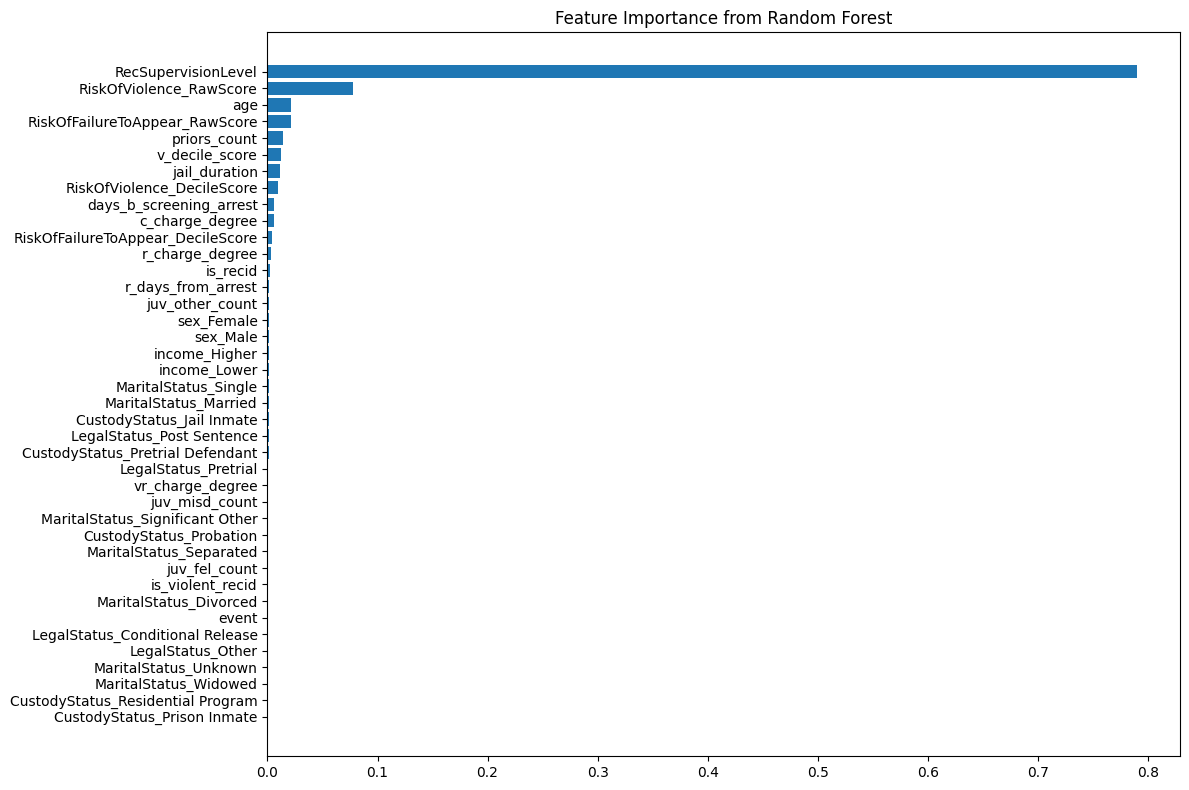


Attempting to use SHAP for additional explanations...


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


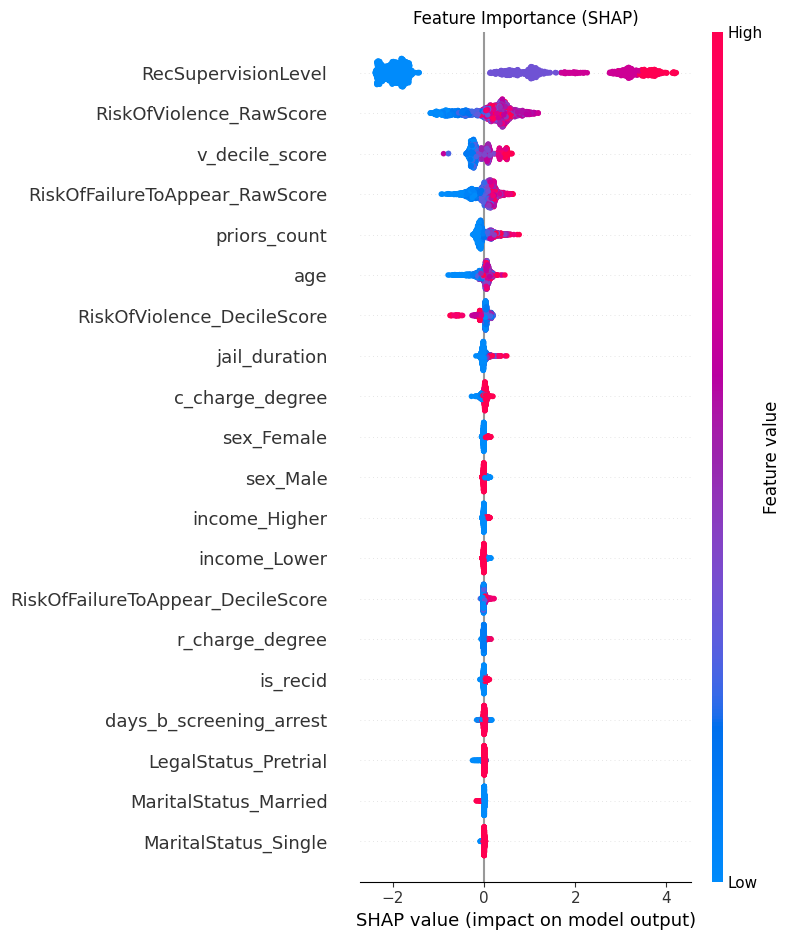

<Figure size 1000x600 with 0 Axes>

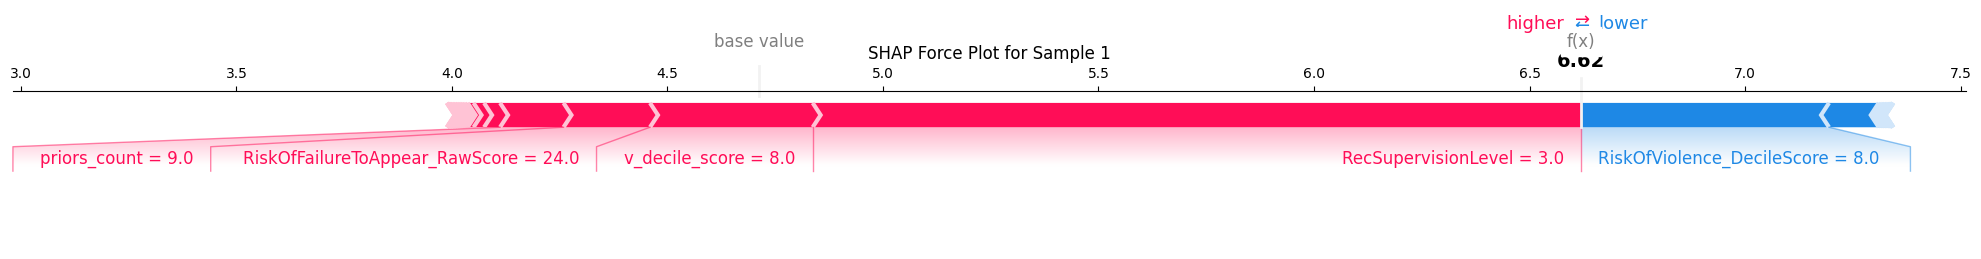

<Figure size 1000x600 with 0 Axes>

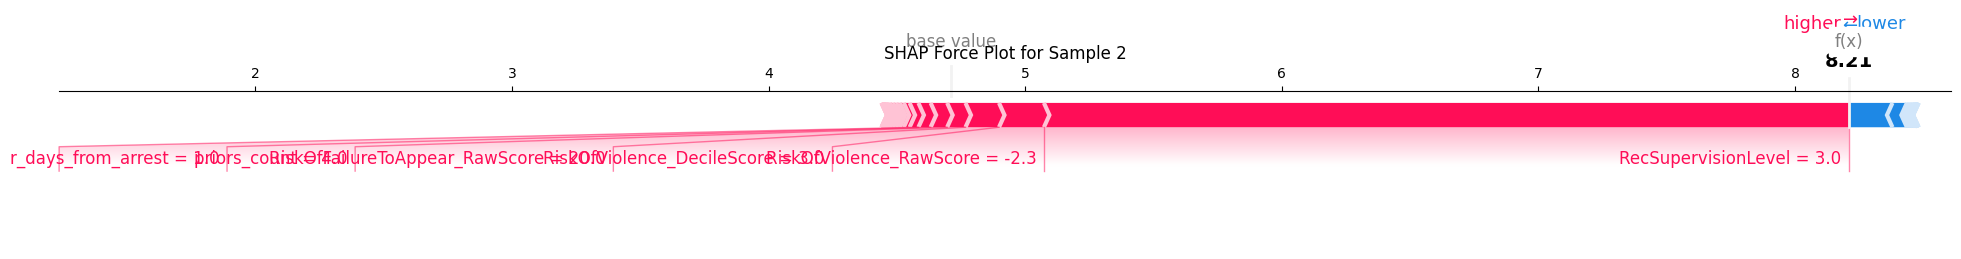

<Figure size 1000x600 with 0 Axes>

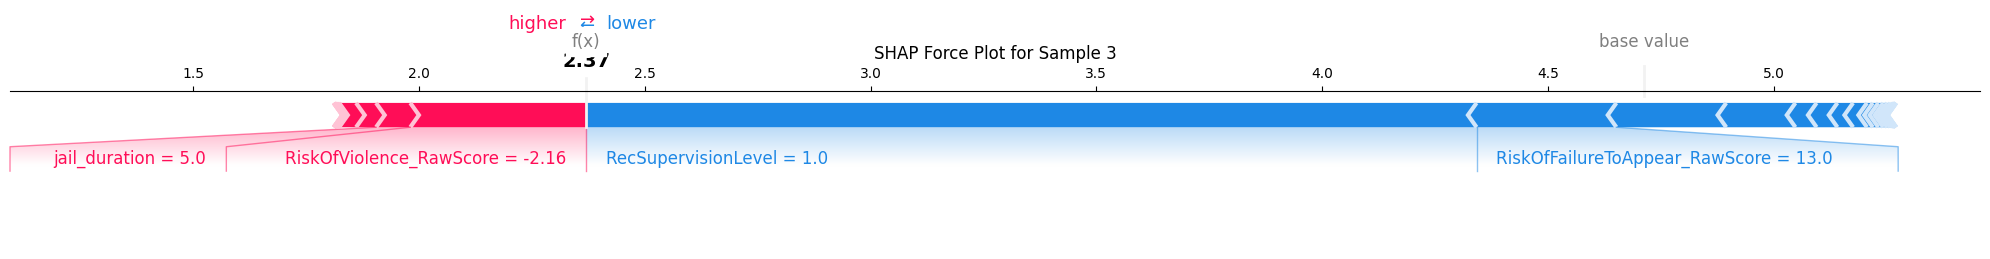

<Figure size 1000x600 with 0 Axes>

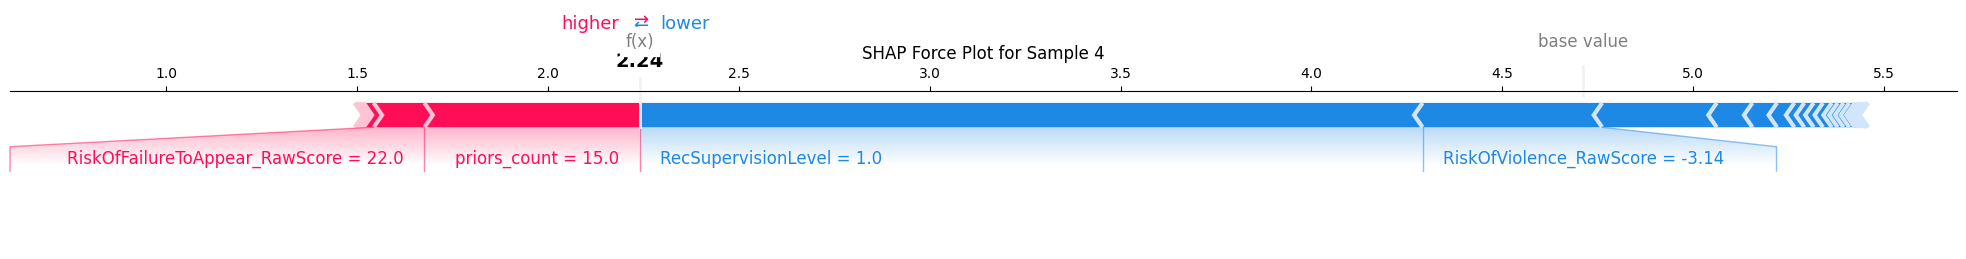

<Figure size 1000x600 with 0 Axes>

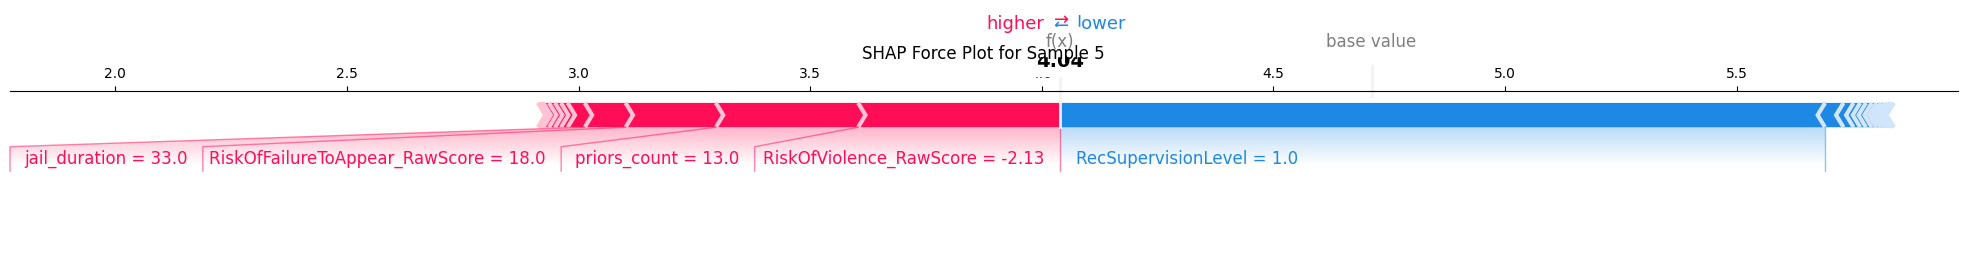


Analysis complete. Model saved to disk.


In [ ]:

# Split the data into features and target
X = data.drop(target_column, axis=1)
y = data[target_column]

# Store feature names for later use
feature_names = X.columns.tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to numpy arrays (often required by PyXAI)
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values

# Train a Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Create PyXAI explainer for Random Forest
# Based on the modules available in pyxai.Explainer
try:
    # Trying to create a PyXAI explainer for Random Forest
    print("Creating PyXAI Random Forest explainer...")

    # Check if this is a regression problem
    is_regression = True

    if is_regression:
        # Attempt to use a regression-specific explainer if available
        try:
            from pyxai.Explainer import BoostedTreesRegression
            explainer = BoostedTreesRegression(model, X_train_np,
                                            y_train_np,
                                            feature_names=feature_names)
            print("Using BoostedTreesRegression explainer")
        except Exception as e:
            print(f"Error using BoostedTreesRegression: {str(e)}")
            # Fall back to standard Random Forest explainer
            explainer = PyXAIRandomForest(model, X_train_np,
                                        feature_names=feature_names)
            print("Using RandomForest explainer")
    else:
        # For classification problems
        explainer = PyXAIRandomForest(model, X_train_np,
                                    feature_names=feature_names)
        print("Using RandomForest explainer")

    # Get feature importance
    try:
        feature_importance = explainer.feature_importance()

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance')
        feature_importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
        plt.title('Feature Importance (PyXAI)')
        plt.tight_layout()
        plt.savefig('pyxai_feature_importance.png')
        plt.show()
    except Exception as e:
        print(f"Error getting feature importance: {str(e)}")

    # Generate explanations for test samples
    print("\nGenerating explanations for test samples...")
    for i in range(min(5, len(X_test))):
        try:
            instance = X_test_np[i].reshape(1, -1)
            # Try different explanation methods available in PyXAI
            try:
                explanation = explainer.explain(instance)
                print(f"\nExplanation for Sample {i+1}:")
                print(f"Actual decile score: {y_test.iloc[i]}")
                print(f"Predicted decile score: {y_pred[i]:.2f}")
                print(f"Explanation: {explanation}")
            except:
                # Try alternative explanation method
                explanation = explainer.explain_instance(instance)
                print(f"\nExplanation for Sample {i+1}:")
                print(f"Actual decile score: {y_test.iloc[i]}")
                print(f"Predicted decile score: {y_pred[i]:.2f}")
                print(f"Explanation: {explanation}")
        except Exception as e:
            print(f"Error explaining instance {i}: {str(e)}")

except Exception as e:
    print(f"Error setting up PyXAI explainer: {str(e)}")
    print("Falling back to basic feature importance...")

    # Basic feature importance from Random Forest
    feature_importances = model.feature_importances_
    indices = np.argsort(feature_importances)

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(indices)), feature_importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('Feature Importance from Random Forest')
    plt.tight_layout()
    plt.savefig('basic_feature_importance.png')
    plt.show()

# Try SHAP as an alternative for better explanations
try:
    print("\nAttempting to use SHAP for additional explanations...")
    import shap
    explainer_shap = shap.TreeExplainer(model)
    shap_values = explainer_shap.shap_values(X_test)

    # Plot SHAP summary
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title('Feature Importance (SHAP)')
    plt.tight_layout()
    plt.savefig('shap_summary.png')
    plt.show()

    # Sample explanations for the first few instances
    for i in range(min(5, len(X_test))):
        plt.figure(figsize=(10, 6))
        shap.force_plot(
            explainer_shap.expected_value,
            shap_values[i],
            X_test.iloc[i],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Sample {i+1}')
        plt.tight_layout()
        plt.savefig(f'shap_force_plot_{i}.png')
        plt.show()
except Exception as e:
    print(f"Error using SHAP: {str(e)}")

# Save the model
import joblib
joblib.dump(model, 'rf_compas_model.pkl')

print("\nAnalysis complete. Model saved to disk.")

drop the risk of ricividism decile score then do it again